# Rainfall in situ comparison

In [2]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import glob
import calendar
import seaborn as sns
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *
from scipy import stats
import itertools

In [5]:
#switch to select 3x3 grid box from reanalyses when comparing to in situ point data
grid_box_select_switch = True

In [6]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [7]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41977/status,
Dashboard: /proxy/41977/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44411,Workers: 0
Dashboard: /proxy/41977/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34537,Total threads: 1
Dashboard: /proxy/34379/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:45077,


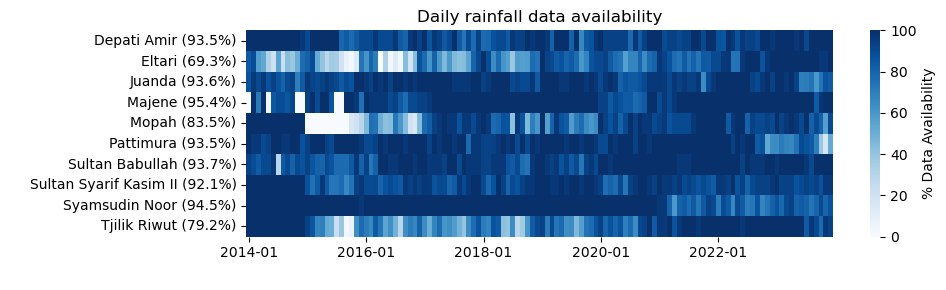

<Figure size 640x480 with 0 Axes>

In [8]:
rain_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/wind-and-rain/hourly-wind/station_metadata.csv').drop(columns=['No']).dropna()
base_dir = '/g/data/qz03/wp3/data/obs/wind-and-rain/daily-wind-rain/'

files = [os.path.join(base_dir, station_name) for station_name in [station_folder for station_folder in os.listdir('/g/data/qz03/wp3/data/obs/wind-and-rain/daily-wind-rain') if '9' in station_folder] if os.path.isfile(os.path.join(base_dir, station_name))]
    
dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f, parse_dates=['time_step']) for f in files}
df_list = [df['time_step'].dt.to_period('M').drop_duplicates() for df in dfs.values()]
all_months = pd.Index(pd.concat(df_list).drop_duplicates()).sort_values()
    
availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
for station, df in dfs.items():
    df['year_month'] = df['time_step'].dt.to_period('M')
    total_per_month = df.groupby('year_month').size()
    avail_per_month = df.groupby('year_month')['RAINFALL_24H_MM'].apply(lambda x: x.notna().sum())
    pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
    availability.loc[station] = pct.values

availability.index = availability.index.str[:5]
new_index = []
for station, df in dfs.items():
    total = len(df)
    available = df['RAINFALL_24H_MM'].notna().sum()
    percent = (available / total) * 100 if total > 0 else 0
    station_name = rain_station_latlon_df[rain_station_latlon_df['WMO ID'] == int(station[:5])]['Station Name'].values[0]
    label = f"{station_name} ({percent:.1f}%)"
    new_index.append(label)

availability.index = new_index
availability.sort_index(inplace=True)
plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
sns.heatmap(availability.astype(float), cmap="Blues", cbar_kws={'label': '% Data Availability'}, xticklabels=24)
plt.title(f"Daily rainfall data availability")
plt.ylabel(' ')
plt.xlabel(' ')
plt.tight_layout()
plt.show()
plt.clf()

In [9]:
rain_station_latlon_df

,Station Name,WMO ID,Lon,Lat
0,Sultan Syarif Kasim II,96109.0,101.44743,0.45924
1,Depati Amir,96237.0,106.13000,-2.17000
2,Tjilik Riwut,96655.0,113.95000,-2.22000
3,Syamsudin Noor,96685.0,114.75400,-3.44200
4,Juanda,96935.0,112.78330,-7.38460
5,Majene,97120.0,118.98054,-3.55074
6,Eltari,97372.0,123.67039,-10.16780
7,Sultan Babullah,97430.0,127.38000,0.83330
8,Pattimura,97724.0,128.09570,-3.71140
9,Mopah,97980.0,140.41568,-8.52019


In [10]:
rain_station_latlon_df.sort_values(by='Station Name', inplace=True)
rain_station_latlon_df['status'] = [1, 2, 1, 1, 1, 1, 1, 1, 1, 2]

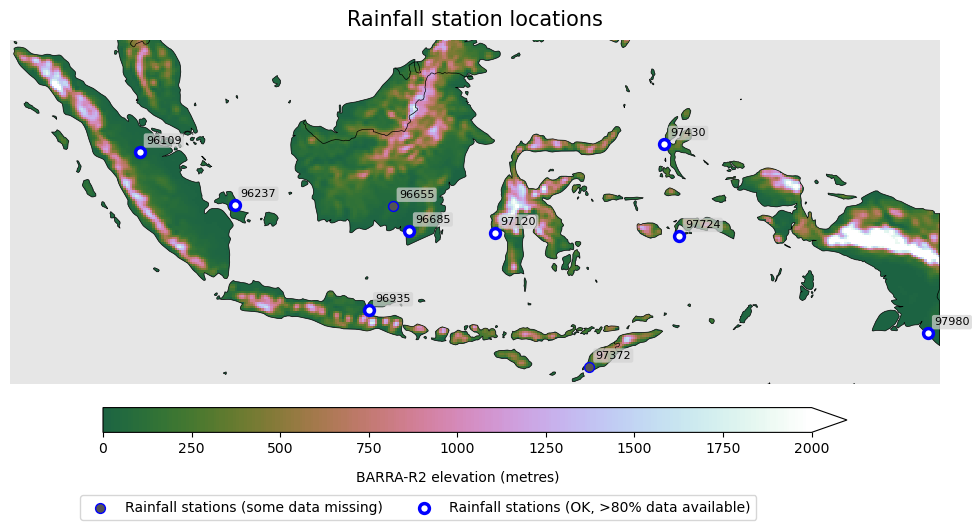

<Figure size 640x480 with 0 Axes>

In [11]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

barra_topo = xr.open_dataset(f'{barraR2_dir}fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').sel(lat=slice(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']), lon=slice(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max']))
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = barra_topo.orog.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmax=2000, cmap=mcolors.LinearSegmentedColormap.from_list('trunc', plt.get_cmap('cubehelix')(np.linspace(5/17, 1, 256))), add_colorbar=False)
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', extend='max', shrink=0.8, aspect=30, pad=0.05)
cbar.set_label('BARRA-R2 elevation (metres)', labelpad=10)
ax.set_title("Rainfall station locations", size=15, pad=10)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
ax.set_frame_on(False)

ax.scatter(rain_station_latlon_df.loc[rain_station_latlon_df['status'] == 2, 'Lon'], rain_station_latlon_df.loc[rain_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='blue', s=50, linewidth=1, label='Rainfall stations (some data missing)', zorder=20)
ax.scatter(rain_station_latlon_df.loc[rain_station_latlon_df['status'] == 1, 'Lon'], rain_station_latlon_df.loc[rain_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='blue', s=50, linewidth=2.5, label='Rainfall stations (OK, >80% data available)', zorder=20)

for _, row in rain_station_latlon_df.iterrows():
    ax.text(row['Lon']+0.3, row['Lat']+0.3, str(int(row['WMO ID'])), transform=ccrs.PlateCarree(),
            fontsize=8, ha='left', va='bottom', zorder=25, color='black', bbox=dict(facecolor='lightgrey', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))


ax.legend(ncol=2, bbox_to_anchor=(0.81, -0.3))
plt.show()
plt.clf()

In [12]:
rain_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/wind-and-rain/hourly-wind/station_metadata.csv').drop(columns=['No']).dropna()
rain_station_df = pd.concat([pd.read_csv(f, parse_dates=['time_step']) for f in glob.glob('/g/data/qz03/wp3/data/obs/wind-and-rain/daily-wind-rain/*.csv')], ignore_index=True)#.replace(0, np.nan, inplace=True)

In [13]:
%%time
barra_rain_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/BARRAR2/1hr/pr/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4')
era_rain_hly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/reanalysis/ERA5/tp/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').rename({'latitude': 'lat'}).rename({'longitude': 'lon'})
barra_daily_resampled = ((barra_rain_hly.sortby("time").pr) * 3600).resample(time='D', offset=pd.Timedelta(hours=7)).sum() #(((barra_rain_hly.sortby("time").pr)*3600).resample(time='D').sum())
era5_daily_resampled = ((era_rain_hly.sortby("time").tp) * 1000).resample(time='D', offset=pd.Timedelta(hours=7)).sum() #(((era_rain_hly.sortby("time").tp)*1000).resample(time='D').sum())

CPU times: user 4.03 s, sys: 576 ms, total: 4.6 s
Wall time: 15.4 s


In [14]:
%%time
era5_daily_resampled = era5_daily_resampled.chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()
barra_daily_resampled = barra_daily_resampled.chunk({'time':720, 'lat':'auto', 'lon':'auto'}).compute()

CPU times: user 2min 33s, sys: 21.3 s, total: 2min 55s
Wall time: 6min 37s


In [15]:
rain_station_df = pd.concat([pd.read_csv(f, parse_dates=['time_step']).assign(station_id=f.split('_')[0].split('/')[-1][:-4]) for f in glob.glob('/g/data/qz03/wp3/data/obs/wind-and-rain/daily-wind-rain/*.csv')], ignore_index=True).drop(columns=['WIND_DIR_24H_MAX_DEG', 'WIND_SPEED_24H_MEAN_MS'])

In [16]:
def grid_box_select(rain_reanalysis, model_res):
    rain = []
    for lat_offset, lon_offset in itertools.product([-model_res, 0, model_res], [-model_res, 0, model_res]):
        rain.append(rain_reanalysis.sel(lat=lat+lon_offset, lon=lon, method='nearest').compute().sortby("time"))
    rain_pt = xr.concat(rain, dim='z').mean('z').compute().sortby("time")
    return rain_pt

def point_select(rain_reanalysis):
    rain_pt = rain_reanalysis.sel(lat=lat, lon=lon, method='nearest').compute().sortby("time")
    return rain_pt

In [17]:
agg_df = []
for station_id in rain_station_latlon_df['WMO ID']:
    lat, lon = rain_station_latlon_df.loc[rain_station_latlon_df['WMO ID'] == station_id, ['Lat', 'Lon']].values[0]
    station_df = rain_station_df[rain_station_df['WMO_ID'] == int(station_id)].copy()
    station_df['time_step'] = pd.to_datetime(station_df['time_step'])

    # BARRA extract
    barra_pr = grid_box_select(barra_daily_resampled, 0.1) if grid_box_select_switch == True else point_select(barra_daily_resampled)

    # ERA5 extract
    era5_pr = grid_box_select(era5_daily_resampled, 0.25) if grid_box_select_switch == True else point_select(era5_daily_resampled)

    # Convert to pandas Series and reset index
    barra_pr_series = barra_pr.to_series().reset_index(name='BARRA_PR').sort_values('time')
    era5_pr_series = era5_pr.to_series().reset_index(name='ERA5_PR').sort_values('time')

    # Merge station data with reanalysis data on time
    df = pd.merge_asof(
    pd.merge_asof(station_df.sort_values('time_step'), barra_pr_series, left_on='time_step', right_on='time', direction='nearest').drop(columns='time'),
    era5_pr_series, left_on='time_step', right_on='time', direction='nearest').drop(columns='time')
    
    agg_df.append(df)

In [18]:
full_rain_df = pd.concat(agg_df)

In [19]:
mbe_barra = {}
rmse_barra = {}
mbe_era5 = {}
rmse_era5 = {}
for station_id in rain_station_latlon_df['WMO ID']:
    station_df = full_rain_df[full_rain_df['WMO_ID'] == int(station_id)]
    mbe_barra[station_id]= (station_df['BARRA_PR']-station_df['RAINFALL_24H_MM']).mean()
    mbe_era5[station_id]= (station_df['ERA5_PR']-station_df['RAINFALL_24H_MM']).mean()

    rmse_barra[station_id]=  np.sqrt(((station_df['BARRA_PR'] - station_df['RAINFALL_24H_MM']) ** 2).mean())
    rmse_era5[station_id]=  np.sqrt(((station_df['ERA5_PR'] - station_df['RAINFALL_24H_MM']) ** 2).mean())

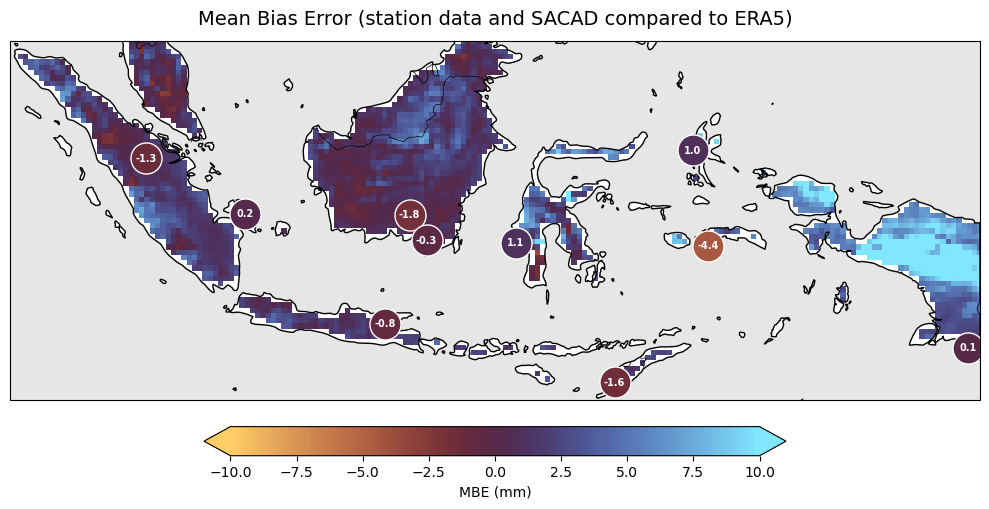

<Figure size 640x480 with 0 Axes>

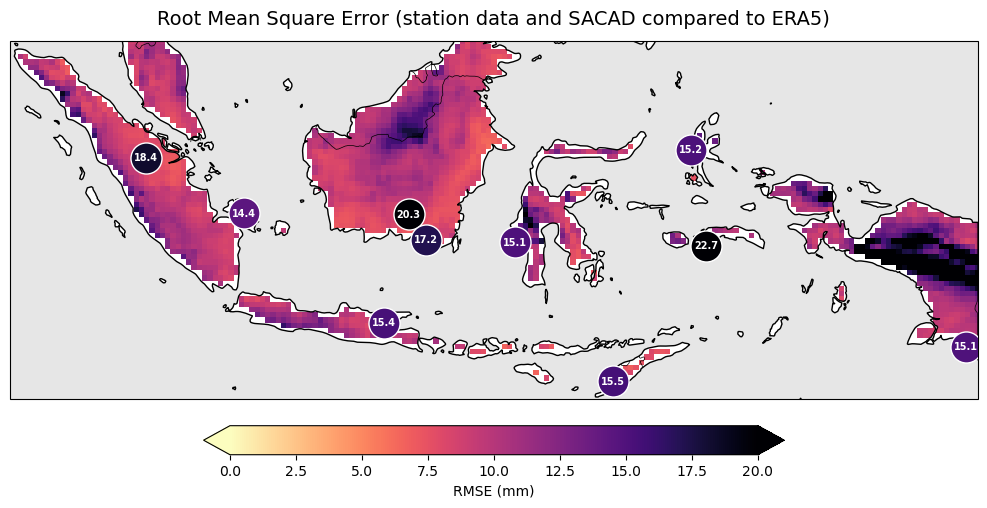

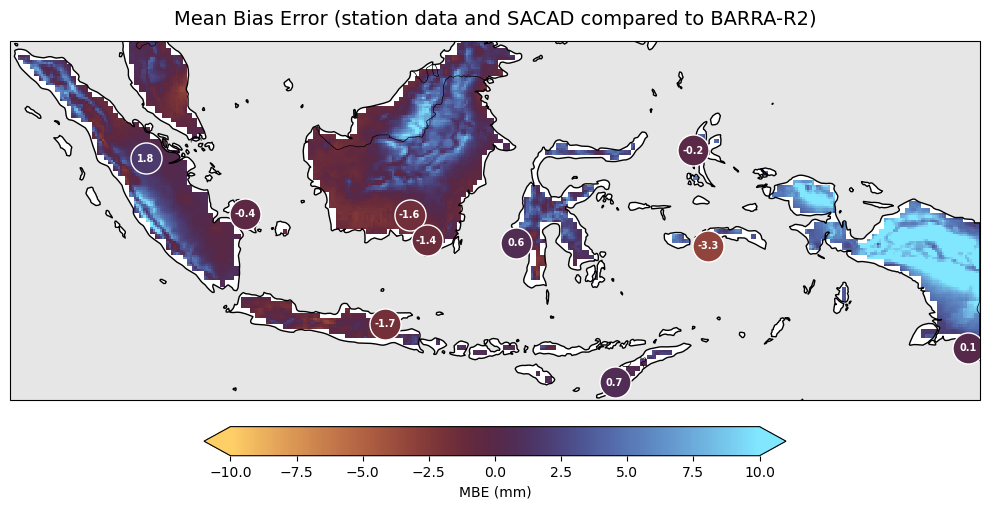

<Figure size 640x480 with 0 Axes>

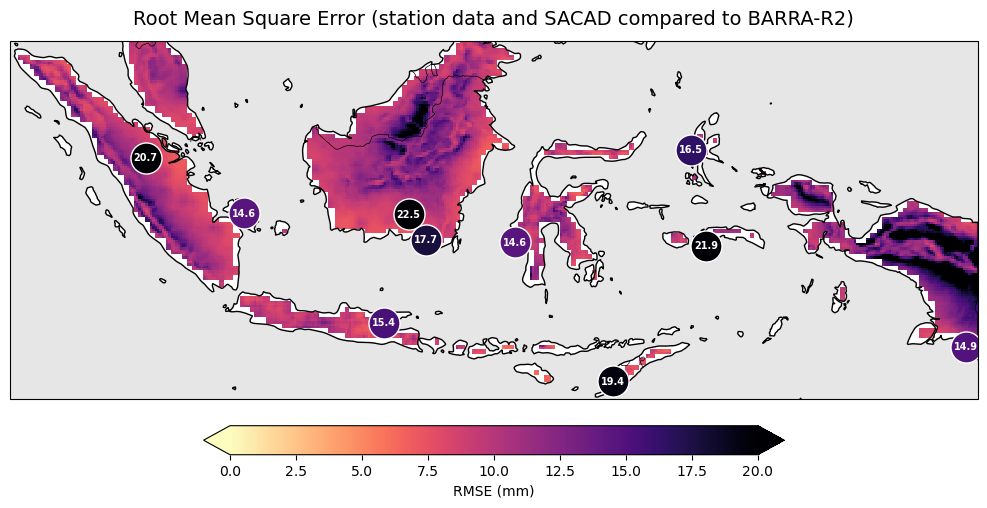

CPU times: user 1min 35s, sys: 3min 44s, total: 5min 20s
Wall time: 4min 48s


In [20]:
%%time
import matplotlib.cm as cm
import matplotlib.colors as colors
# import managua

barra_daily_resampled = barra_daily_resampled.sel(time=slice('1981-01-01','2017-12-31'))
era5_daily_resampled = era5_daily_resampled.sel(time=slice('1981-01-01','2017-12-31'))

station_dicts = [
    {'mbe': mbe_era5, 'rmse': rmse_era5},
    {'mbe': mbe_barra, 'rmse': rmse_barra}
]

for reanalysis_idx, reanalysis_xr in enumerate([era5_daily_resampled, barra_daily_resampled]):
    SACAD_rain_dly = xr.open_dataset('/g/data/qz03/wp3/data/obs/wind-and-rain/gridded-SACAD/rr_0.25deg_reg_v2.0_saobs.nc')\
                        .rename({'latitude': 'lat', 'longitude': 'lon'})
    SACAD_rain_dly = SACAD_rain_dly.rr.interp_like(reanalysis_xr)
    
    # ----------------- MBE plot -----------------
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_array = (reanalysis_xr - SACAD_rain_dly).mean(dim='time')
    
    # Define colormap and normalization for MBE
    cmap = cm.get_cmap('managua')
    norm = colors.Normalize(vmin=-10, vmax=10)
    
    plot_item = plot_array.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap=cmap, add_colorbar=False)
    cbar = fig.colorbar(plot_item, ax=ax, orientation='horizontal', pad=0.05, fraction=0.07, shrink=0.6, extend='both', label='MBE (mm)')
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                   domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
    
    # Overlay station MBE points with color mapped to value
    for _, row in rain_station_latlon_df.iterrows():
        station_id = row['WMO ID']
        mbe_val = station_dicts[reanalysis_idx]['mbe'][station_id]
        ax.scatter(row['Lon'], row['Lat'], color=cmap(norm(mbe_val)), s=500, edgecolor='white', zorder=5)  # bigger dots
        ax.text(row['Lon'], row['Lat'], f"{mbe_val:.1f}", color='white', fontsize=7,
                ha='center', va='center', zorder=6, fontweight='bold')
    
    ax.set_title(f"Mean Bias Error (station data and SACAD compared to {'ERA5' if reanalysis_idx == 0 else 'BARRA-R2'})", fontsize=14, pad=12)
    plt.tight_layout()
    plt.show()
    plt.clf()
    
    # ----------------- RMSE plot -----------------
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_array = np.sqrt(((reanalysis_xr - SACAD_rain_dly) ** 2).mean(dim='time'))
    
    cmap = cm.get_cmap('magma_r')
    norm = colors.Normalize(vmin=0, vmax=20)
    
    plot_item = plot_array.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=20, cmap=cmap, add_colorbar=False)
    cbar = fig.colorbar(plot_item, ax=ax, orientation='horizontal', pad=0.05, fraction=0.07, shrink=0.6, extend='both', label='RMSE (mm)')
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                   domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
    
    # Overlay station RMSE points with color mapped to value
    for _, row in rain_station_latlon_df.iterrows():
        station_id = row['WMO ID']
        rmse_val = station_dicts[reanalysis_idx]['rmse'][station_id]
        ax.scatter(row['Lon'], row['Lat'], color=cmap(norm(rmse_val)), s=500, edgecolor='white', zorder=5)  # bigger dots
        ax.text(row['Lon'], row['Lat'], f"{rmse_val:.1f}", color='white', fontsize=7,
                ha='center', va='center', zorder=6, fontweight='bold')
    
    ax.set_title(f"Root Mean Square Error (station data and SACAD compared to {'ERA5' if reanalysis_idx == 0 else 'BARRA-R2'})", fontsize=14, pad=12)
    plt.tight_layout()
    plt.show()